In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

In [2]:
# Find the url for 10 pages
base_url="https://www.imdb.com/search/title/?title_type=feature\
&release_date=1930-01-01,2020-12-31\
&countries=us\
&languages=en&count=100"

url_list=[base_url]
for i in range(101,5001,100):
    url = base_url+ "&start=" + str(i) + "&ref_=adv_nxt"
    url_list.append(url)

In [97]:
base_url

'https://www.imdb.com/search/title/?title_type=feature&release_date=1930-01-01,2020-12-31&countries=us&languages=en&count=100'

In [104]:
len(url_list)

50

In [4]:
# Create soup_list (13 soup for 13 pages)
def get_soup(url):
    response = requests.get(url)
    page = response.text
    soup = BeautifulSoup(page, "lxml")
    return soup

In [5]:
soup_list=[]
for url in url_list:
    soup_list.append(get_soup(url))

In [105]:
len(soup_list)

50

In [7]:
# Create movie_div_list (2000 movies, 100 movies a page)
# sort by popularity
movie_div_list=[]
for soup in soup_list:
    for movie in soup.find_all('div',class_="lister-item-content"):
        movie_div_list.append(movie)

In [106]:
len(movie_div_list)

5000

In [9]:
# Create movie_url_list (individual webpage for each movie)

movie_url_list=[]
movie_base_url = "https://www.imdb.com/"

for soup in soup_list:
    divs= [div for div in soup.find_all('div', class_="lister-item-content")]

    for i in range(100):
        movie_url = divs[i].find('a').get('href')
        movie_url_list.append(movie_base_url + movie_url)

In [107]:
len(movie_url_list)

5000

In [11]:
# Create soup_list for the movies

movie_soup_list=[]
for movie_url in movie_url_list[:100]:
    movie_soup = get_soup(movie_url)
    movie_soup_list.append(movie_soup)

In [12]:
len(movie_soup_list)

100

In [13]:
for movie_url in movie_url_list[100:200]:
    movie_soup = get_soup(movie_url)
    movie_soup_list.append(movie_soup)

In [14]:
len(movie_soup_list)

200

In [15]:
for movie_url in movie_url_list[200:500]:
    movie_soup = get_soup(movie_url)
    movie_soup_list.append(movie_soup)

In [16]:
len(movie_soup_list)

500

In [17]:
for movie_url in movie_url_list[500:800]:
    movie_soup = get_soup(movie_url)
    movie_soup_list.append(movie_soup)

In [18]:
len(movie_soup_list)

800

In [19]:
for movie_url in movie_url_list[800:]:
    movie_soup = get_soup(movie_url)
    movie_soup_list.append(movie_soup)

In [108]:
len(movie_soup_list)

5000

In [196]:
# get detailed data from individual movie webpage
# fixed-- why it's all nan??
# fixed -- runtime

def get_movie_detail(soup):
    
    headers=['movie_title', 'rating', 'vote', 'certificate', 'genre', 'release_date', 'metascore', 'keywords','budget',\
            'opening_weekend_usa','gross_usa','gross_world','runtime',\
             'distributor','language','country',\
             'director','writer','star',\
             'link_d','link_w','link_s']
    
    # find movie title
    title = " ".join(soup.find('h1').text.split()[:-1]) ## problem?
    
    # find rating
#     rating = float(soup.find('span',attrs={'itemprop':'ratingValue'}).text)
    if soup.find('span',attrs={'itemprop':'ratingValue'}) is not None:
        rating = float(soup.find('span',attrs={'itemprop':'ratingValue'}).text)
    else:
        rating = np.nan
    
    # find vote (rating count)
#     vote = int(soup.find('span',attrs={'itemprop':'ratingCount'}).text.replace(',',''))
    if soup.find('span',attrs={'itemprop':'ratingCount'}) is not None:
        vote = int(soup.find('span',attrs={'itemprop':'ratingCount'}).text.replace(',',''))
    else:
        vote = np.nan
    
    # find content rating
#     certificate = soup.find('div', class_="subtext").text.split()[0]
    if soup.find('div', class_="subtext") is not None:
        certificate = soup.find('div', class_="subtext").text.split()[0]
    else:
        certificate = np.nan
    
    # find list of genre
    genre_list=[]
    try:
        for genres in soup.find('div', class_="subtext").find_all('a')[:-1]:
            genre_list.append(genres.text)
    except:
        pass
                 
        
    # find release date
    date = np.nan
    try:
                 
        date_pre = soup.find('div', class_="subtext").find_all('a')[-1].text.split('(')[0]
        date = pd.to_datetime(date_pre) ## why is it Timestamp? format ='%d-%B-%Y'
                 
    except:
        pass
    
    # find metascorre
    if soup.find('div',class_="metacriticScore score_favorable titleReviewBarSubItem") is not None:
        meta = int(soup.find('div',class_="metacriticScore score_favorable titleReviewBarSubItem").text.strip('\n'))
    else:
        meta = np.nan
        
        
    # find plot keywords
    keyword_list=[]
    try:
        for keywords in soup.find('div', class_="article", id="titleStoryLine").\
        find('div', class_="see-more inline canwrap").find_all('a')[:-1]:
            keyword_list.append(keywords.text.strip(' '))
    except:
        pass
    
    
    # find budget, opening weekend USA, gross USA, cumulative worldwide gross, distributor
    # assign default value:
    budget, opening, gross_usa, gross_cw, distributor = np.nan, np.nan, np.nan, np.nan, np.nan
    for line in soup.find('div', class_="article", id="titleDetails").find_all('h4'):        
        if "Budget:" in line:
            budget = int(''.join(s for s in line.next_sibling if s.isdigit()))
        if "Opening Weekend USA:" in line:
            opening = int(''.join(s for s in line.next_sibling if s.isdigit()))
        if "Gross USA:" in line:
            gross_usa = int(''.join(s for s in line.next_sibling if s.isdigit()))
        if "Cumulative Worldwide Gross:" in line:
            gross_cw = int(''.join(s for s in line.next_sibling if s.isdigit()))
        if "Production Co:" in line:
            distributor = line.findNext().text.replace(' ','')


    # find runtime
    runtime = np.nan
    try:
        runtime = int(soup.find_all('time')[-1].text.strip(' min'))
    except:
        pass

    # find director
    director= np.nan
    director = soup.find('div',class_="credit_summary_item").find('a').text
    link_d = soup.find('div',class_="credit_summary_item").find('a').get('href')
    
    # find writer
    writer = np.nan
    writer_line = soup.find_all('div',class_="credit_summary_item")[1].find_all('a')
    link_w = [w.get('href') for w in writer_line]
    writer = [w.text for w in writer_line]
    if '1 more credit' in writer:
        writer.remove('1 more credit')
        link_w.pop()
        
    # find star
    star = np.nan
    star_line = soup.find_all('div',class_="credit_summary_item")[-1].find_all('a')
    link_s = [s.get('href') for s in star_line]
    star = [s.text for s in star_line]
    if 'See full cast & crew' in star:
        star.remove('See full cast & crew')
        link_s.pop()
    
    
    
    # find language
    language= np.nan
    t= []
    matching = []
    for div in soup.find('div', class_="article", id="titleDetails").find_all('div'):
        t.append(div.text.replace('\n','').replace(' ',''))
    
    matching = [s for s in t if 'Language:' in s]
    language = matching[0].replace(':',' ').replace('|',' ').split(' ')[1:]
    
    
    # find country
    country= np.nan
    t= []
    matching = []
    for div in soup.find('div', class_="article", id="titleDetails").find_all('div'):
        t.append(div.text.replace('\n','').replace(' ',''))
    
    matching = [s for s in t if 'Country:' in s]
    country = matching[0].replace(':',' ').replace('|',' ').split(' ')[1:]
    
    
    
    movie_dict = dict(zip(headers, [title,
                                    rating,
                                    vote,
                                   certificate,
                                   genre_list,
                                   date,
                                   meta,
                                   keyword_list,
                                   budget,
                                   opening,
                                   gross_usa,
                                   gross_cw,
                                   runtime,
                                    distributor,
                                    language,
                                    country,
                                   director,
                                    writer,
                                   star,
                                   link_d,
                                    link_w,
                                    link_s,
                                   ]))
    
    return movie_dict

In [198]:
# movie_df[movie_df.runtime.isna()==True]

In [199]:
# movie_df.info()

In [200]:
# Create list of movie_dict
movie_detail_data=[]
for movie_soup in movie_soup_list:
    movie = get_movie_detail(movie_soup)
    movie_detail_data.append(movie)

In [201]:
len(movie_detail_data)

5000

In [153]:
for movie_soup in movie_soup_list[4386:]:
    movie = get_movie_detail(movie_soup)
    movie_detail_data.append(movie)

In [169]:
len(movie_detail_data)

4999

In [155]:
# movie_detail_data[-1]

In [177]:
soup = movie_soup_list[0]
# movie_url_list[4386]

In [176]:
movie_url_list.index('https://www.imdb.com//title/tt11161474/')

0

In [197]:
get_movie_detail(soup)

{'movie_title': 'Pieces of a Woman',
 'rating': 7.1,
 'vote': 16183,
 'certificate': 'R',
 'genre': ['Drama'],
 'release_date': Timestamp('2021-01-07 00:00:00'),
 'metascore': 66,
 'keywords': ['female frontal nudity',
  'female nudity',
  'male frontal nudity',
  'male nudity',
  'male rear nudity'],
 'budget': nan,
 'opening_weekend_usa': nan,
 'gross_usa': nan,
 'gross_world': nan,
 'runtime': 126,
 'distributor': 'BRONStudios',
 'language': ['English'],
 'country': ['Canada', 'Hungary', 'USA'],
 'director': 'Kornél Mundruczó',
 'writer': ['Kata Wéber'],
 'star': ['Vanessa Kirby', 'Shia LaBeouf', 'Ellen Burstyn'],
 'link_d': '/name/nm0610960/',
 'link_w': ['/name/nm0970537/'],
 'link_s': ['/name/nm3948952/', '/name/nm0479471/', '/name/nm0000995/']}

In [175]:
movie_url_list[0]

'https://www.imdb.com//title/tt11161474/'

In [157]:
# get_movie_detail(soup)

In [202]:
# Create pd DataFrame of 2000 movies!
movie_df = pd.DataFrame(movie_detail_data)
movie_df.sort_values('gross_world',ascending=False)

,movie_title,rating,vote,certificate,genre,release_date,metascore,keywords,budget,opening_weekend_usa,...,runtime,distributor,language,country,director,writer,star,link_d,link_w,link_s
18,Avengers: Endgame,8.4,804009.0,PG-13,"[Action, Adventure, Drama]",2019-04-26,78.0,"[time travel, superhero, cosmic, super villain...",356000000.0,357115007.0,...,181.0,MarvelStudios,"[English, Japanese, Xhosa, German]",[USA],Anthony Russo,"[Christopher Markus, Stephen McFeely, 14 more ...","[Robert Downey Jr., Chris Evans, Mark Ruffalo]",/name/nm0751577/,"[/name/nm1321655/, /name/nm1321656/, fullcredi...","[/name/nm0000375/, /name/nm0262635/, /name/nm0..."
259,Avatar,7.8,1117523.0,PG-13,"[Action, Adventure, Fantasy]",2009-12-18,83.0,"[spiritualism, paraplegic, marine, future, for...",237000000.0,77025481.0,...,178.0,TwentiethCenturyFox,"[English, Spanish]",[USA],James Cameron,[James Cameron],"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",/name/nm0000116/,[/name/nm0000116/],"[/name/nm0941777/, /name/nm0757855/, /name/nm0..."
73,Titanic,7.8,1043823.0,PG-13,"[Drama, Romance]",1997-12-19,75.0,"[iceberg, sailor's death, mass death, titanic,...",200000000.0,28638131.0,...,194.0,TwentiethCenturyFox,"[English, Swedish, Italian, French]","[USA, Mexico]",James Cameron,[James Cameron],"[Leonardo DiCaprio, Kate Winslet, Billy Zane]",/name/nm0000116/,[/name/nm0000116/],"[/name/nm0000138/, /name/nm0000701/, /name/nm0..."
195,Star Wars: Episode VII - The Force Awakens,7.9,859537.0,PG-13,"[Action, Adventure, Sci-Fi]",2015-12-18,80.0,"[reboot, sanitation employee, remake, wisecrac...",245000000.0,247966675.0,...,138.0,Lucasfilm,[English],[USA],J.J. Abrams,"[Lawrence Kasdan, J.J. Abrams, 2 more credits]","[Daisy Ridley, John Boyega, Oscar Isaac]",/name/nm0009190/,"[/name/nm0001410/, /name/nm0009190/, fullcredi...","[/name/nm5397459/, /name/nm3915784/, /name/nm1..."
69,Avengers: Infinity War,8.4,830712.0,PG-13,"[Action, Adventure, Sci-Fi]",2018-04-27,68.0,"[death of recurring character, superhero, supe...",321000000.0,257698183.0,...,149.0,MarvelStudios,[English],[USA],Anthony Russo,"[Christopher Markus, Stephen McFeely, 14 more ...","[Robert Downey Jr., Chris Hemsworth, Mark Ruff...",/name/nm0751577/,"[/name/nm1321655/, /name/nm1321656/, fullcredi...","[/name/nm0000375/, /name/nm1165110/, /name/nm0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4985,On the Town,7.4,16025.0,Passed,"[Comedy, Musical, Romance]",1949-12-30,71.0,"[shore leave, central park, empire state build...",2111250.0,NaN,...,98.0,Metro-Goldwyn-Mayer(MGM),[English],[USA],Stanley Donen,"[Adolph Green, Betty Comden, 3 more credits]","[Gene Kelly, Frank Sinatra, Betty Garrett]",/name/nm0002045/,"[/name/nm0337582/, /name/nm0173679/, fullcredi...","[/name/nm0000037/, /name/nm0000069/, /name/nm0..."
4990,After the Thin Man,7.7,9483.0,Passed,"[Comedy, Crime, Mystery]",1936-12-25,NaN,"[four word title, dead body, hotel room, hotel...",683000.0,NaN,...,112.0,Metro-Goldwyn-Mayer(MGM),[English],[USA],W.S. Van Dyke,"[Frances Goodrich, Albert Hackett]","[William Powell, Myrna Loy, James Stewart]",/name/nm0886754/,"[/name/nm0329304/, /name/nm0352443/]","[/name/nm0001635/, /name/nm0001485/, /name/nm0..."
4991,One Night in Bangkok,5.0,1364.0,R,"[Action, Crime, Drama]",2020-08-25,NaN,"[contract killer, taxi driver, hitman]",NaN,NaN,...,105.0,GrindstoneEntertainmentGroup,[English],[USA],Wych Kaosayananda,[Wych Kaosayananda],"[Mark Dacascos, Vanida Golten, Prinya Intachai]",/name/nm1126346/,[/name/nm1126346/],"[/name/nm0001092/, /name/nm11596317/, /name/nm..."
4992,Deathsport,4.1,1604.0,R,"[Action, Drama, Sci-Fi]",1978-04-01,NaN,"[person on fire, tortured to death, sadist, fe...",NaN,NaN,...,82.0,NewWorldPictures,[English],[USA],Allan Arkush,"[Nicholas Niciphor, Donald E. Stewart]","[David Carradine, Claudia Jennings, Richard Ly...",/name/nm0035106/,"[/name/nm0629947/, /name/nm0829329/]","[/name/nm0001016/, /name/nm0421128/, /name/nm0..."


In [203]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   movie_title          5000 non-null   object        
 1   rating               4999 non-null   float64       
 2   vote                 4999 non-null   float64       
 3   certificate          5000 non-null   object        
 4   genre                5000 non-null   object        
 5   release_date         5000 non-null   datetime64[ns]
 6   metascore            1925 non-null   float64       
 7   keywords             5000 non-null   object        
 8   budget               3980 non-null   float64       
 9   opening_weekend_usa  3937 non-null   float64       
 10  gross_usa            4115 non-null   float64       
 11  gross_world          4429 non-null   float64       
 12  runtime              4994 non-null   float64       
 13  distributor          4992 non-nul

In [204]:
# Save the data to pickle file
movie_df.to_pickle('../dump/movie_data_general')

### Simple data visualization

In [205]:
# Test loading data from dump
movie_df = pd.read_pickle('../dump/movie_data_general')

In [186]:
movie_df

,movie_title,rating,vote,certificate,genre,release_date,metascore,keywords,budget,opening_weekend_usa,...,gross_world,runtime,distributorlanguage,country,director,writer,star,link_d,link_w,link_s
0,Pieces of a Woman,7.1,16183.0,R,[Drama],2021-01-07,66.0,"[female frontal nudity, female nudity, male fr...",NaN,NaN,...,NaN,126.0,BRONStudios,[English],"[Canada, Hungary, USA]",Kornél Mundruczó,[Kata Wéber],"[Vanessa Kirby, Shia LaBeouf, Ellen Burstyn]",/name/nm0610960/,[/name/nm0970537/]
1,Soul,8.1,141473.0,PG,"[Animation, Adventure, Comedy]",2020-12-25,83.0,"[purpose, soul, lost soul, cat, afterlife]",NaN,NaN,...,57400000.0,100.0,WaltDisneyPictures,[English],[USA],Pete Docter,"[Pete Docter, Mike Jones]","[Jamie Foxx, Tina Fey, Graham Norton]",/name/nm0230032/,"[/name/nm0230032/, /name/nm0428873/]"
2,Wonder Woman 1984,5.4,138578.0,PG-13,"[Action, Adventure, Fantasy]",2020-12-25,NaN,"[princess, sequel, dc extended universe, actio...",NaN,NaN,...,142500000.0,151.0,AtlasEntertainment,[English],"[USA, UK, Spain]",Patty Jenkins,"[Patty Jenkins, Geoff Johns, 4 more credits]","[Gal Gadot, Chris Pine, Kristen Wiig]",/name/nm0420941/,"[/name/nm0420941/, /name/nm0424315/, fullcredi..."
3,Tenet,7.5,272191.0,PG-13,"[Action, Sci-Fi, Thriller]",2020-09-03,69.0,"[written by director, car chase, time paradox,...",205000000.0,20200000.0,...,363129000.0,150.0,WarnerBros.,"[English, Russian, Ukrainian, Estonian, Norweg...","[UK, USA]",Christopher Nolan,[Christopher Nolan],"[John David Washington, Robert Pattinson, Eliz...",/name/nm0634240/,[/name/nm0634240/]
4,Promising Young Woman,7.5,15211.0,R,"[Crime, Drama, Thriller]",2020-12-25,72.0,"[revenge, rape and revenge, female protagonist...",NaN,719305.0,...,4187749.0,113.0,FilmNationEntertainment,[English],"[UK, USA]",Emerald Fennell,[Emerald Fennell],"[Carey Mulligan, Bo Burnham, Alison Brie]",/name/nm2193504/,[/name/nm2193504/]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,Austenland,6.3,19247.0,PG-13,"[Comedy, Romance]",2013-09-27,NaN,"[f rated, title directed by female, title writ...",4900000.0,40662.0,...,2313509.0,97.0,FickleFishFilms,[English],"[UK, USA]",Jerusha Hess,"[Jerusha Hess, Shannon Hale]","[Keri Russell, JJ Feild, Jennifer Coolidge]",/name/nm1415801/,"[/name/nm1415801/, /name/nm4539250/]"
4996,Made,6.4,17324.0,R,"[Comedy, Crime, Drama]",2001-08-31,62.0,"[new york city, stripper, directorial debut, f...",5000000.0,118003.0,...,5480653.0,95.0,ArtisanEntertainment,"[English, French]",[USA],Jon Favreau,[Jon Favreau],"[Vince Vaughn, Jon Favreau, Joe Goossen]",/name/nm0269463/,[/name/nm0269463/]
4997,Monster Hunters,2.2,341.0,Unrated,"[Action, Sci-Fi, Thriller]",2020-08-25,NaN,"[cgi, alien, us army, blood splatter, reused f...",NaN,NaN,...,NaN,88.0,TheAsylum,[English],[USA],Brendan Petrizzo,[Jeremy M. Inman],"[Tom Sizemore, Anthony Jensen, Connie Jo Sechr...",/name/nm8375627/,[/name/nm2877888/]
4998,Amazon Women on the Moon,6.2,9954.0,R,"[Comedy, Sci-Fi]",1987-09-18,NaN,"[topless female nudity, blonde, scantily clad ...",NaN,171723.0,...,548696.0,85.0,UniversalPictures,[English],[USA],Joe Dante,"[Michael Barrie, Jim Mulholland]","[Rosanna Arquette, Michelle Pfeiffer, Arsenio ...",/name/nm0001102/,"[/name/nm0057398/, /name/nm0611848/]"


In [187]:
# Check years
movie_df.release_date.dt.year.nunique()
# np.sort(movie_detail_df.release_date.dt.year.unique())

90

In [188]:
movie_df.columns

Index(['movie_title', 'rating', 'vote', 'certificate', 'genre', 'release_date',
       'metascore', 'keywords', 'budget', 'opening_weekend_usa', 'gross_usa',
       'gross_world', 'runtime', 'distributorlanguage', 'country', 'director',
       'writer', 'star', 'link_d', 'link_w', 'link_s'],
      dtype='object')

(array([3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 3, '3.0'),
  Text(0, 4, '4.0'),
  Text(0, 5, '5.0'),
  Text(0, 6, '6.0'),
  Text(0, 7, '7.0'),
  Text(0, 8, '8.0'),
  Text(0, 9, '9.0')])

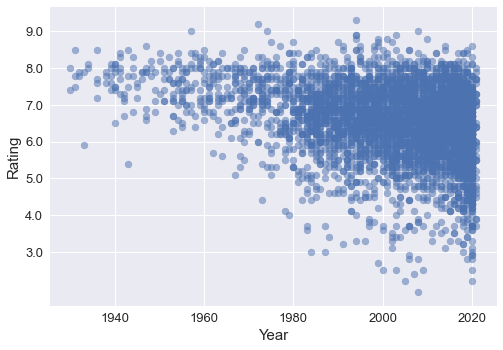

In [189]:
x = movie_df['release_date'].dt.year
y = movie_df['rating']
fig, ax = plt.subplots(1,1)
plt.scatter(x,y,alpha=0.5)
ax.set_title('',fontsize=15)
ax.set_xlabel('Year',fontsize=15)
ax.set_ylabel('Rating',fontsize=15)
ax.set_yticks([3,4,5,6,7,8,9])
ax.set_yticklabels(['3.0','4.0','5.0','6.0','7.0','8.0','9.0'])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

(5000, 21)

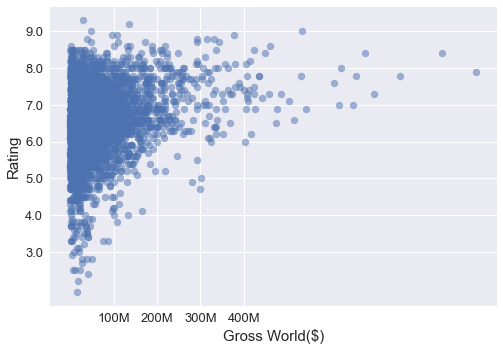

In [190]:
movie_df.dropna(subset=['gross_usa'])
x = movie_df['gross_usa']
y = movie_df['rating']
fig, ax = plt.subplots(1,1)
plt.scatter(x,y,alpha=0.5)
ax.set_title('',fontsize=15)
ax.set_xlabel('Gross World($)',fontsize=15)
ax.set_ylabel('Rating',fontsize=15)
ax.set_xticks([100e6,200e6,300e6,400e6])
ax.set_xticklabels(['100M','200M','300M','400M'])
ax.set_yticks([3,4,5,6,7,8,9])
ax.set_yticklabels(['3.0','4.0','5.0','6.0','7.0','8.0','9.0'])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
movie_df.shape

(array([3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 3, '3.0'),
  Text(0, 4, '4.0'),
  Text(0, 5, '5.0'),
  Text(0, 6, '6.0'),
  Text(0, 7, '7.0'),
  Text(0, 8, '8.0'),
  Text(0, 9, '9.0')])

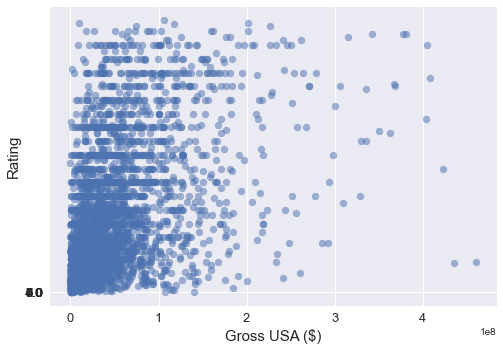

In [191]:
movie_df.dropna(subset=['budget'])
x = movie_df[movie_df.budget < 1e8]['gross_usa']
y = movie_df[movie_df.budget < 1e8]['budget']
fig, ax = plt.subplots(1,1)
plt.scatter(x,y,alpha=0.5)
ax.set_title('',fontsize=15)
ax.set_xlabel('Gross USA ($)',fontsize=15)
ax.set_ylabel('Rating',fontsize=15)
# ax.set_xticks([100e6,200e6,300e6,400e6])
# ax.set_xticklabels(['100M','200M','300M','400M'])
ax.set_yticks([3,4,5,6,7,8,9])
ax.set_yticklabels(['3.0','4.0','5.0','6.0','7.0','8.0','9.0'])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

(array([3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 3, '3.0'),
  Text(0, 4, '4.0'),
  Text(0, 5, '5.0'),
  Text(0, 6, '6.0'),
  Text(0, 7, '7.0'),
  Text(0, 8, '8.0'),
  Text(0, 9, '9.0')])

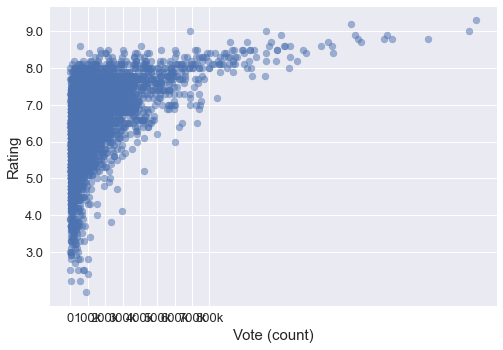

In [192]:
movie_df.dropna(subset=['vote'])
x = movie_df['vote']
y = movie_df['rating']

fig, ax = plt.subplots(1,1)
plt.scatter(x,y,alpha=0.5)
ax.set_title('',fontsize=15)
ax.set_xlabel('Vote (count)',fontsize=15)
ax.set_ylabel('Rating',fontsize=15)
ax.set_xticks([0,100e3,200e3,300e3,400e3,500e3,600e3,700e3,800e3])
ax.set_xticklabels(['0','100k','200k','300k','400k','500k','600k','700k','800k',])
ax.set_yticks([3,4,5,6,7,8,9])
ax.set_yticklabels(['3.0','4.0','5.0','6.0','7.0','8.0','9.0'])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

(array([3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 3, '3.0'),
  Text(0, 4, '4.0'),
  Text(0, 5, '5.0'),
  Text(0, 6, '6.0'),
  Text(0, 7, '7.0'),
  Text(0, 8, '8.0'),
  Text(0, 9, '9.0')])

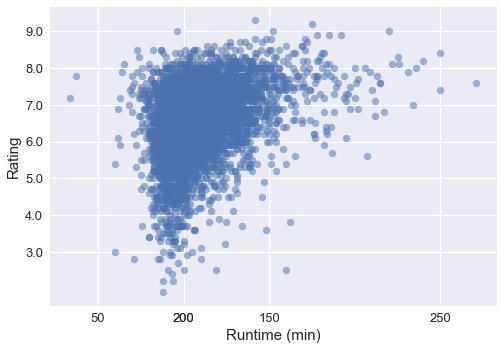

In [193]:
movie_df.dropna(subset=['runtime'])
movie_df = movie_df[movie_df.runtime <300]
x = movie_df['runtime']
y = movie_df['rating']

fig, ax = plt.subplots(1,1)
plt.scatter(x,y,alpha=0.5)
ax.set_title('',fontsize=15)
ax.set_xlabel('Runtime (min)',fontsize=15)
ax.set_ylabel('Rating',fontsize=15)

ax.set_xticks([50,100,150,100,250])
ax.set_xticklabels(['50','100','150','200','250'])
ax.set_yticks([3,4,5,6,7,8,9])
ax.set_yticklabels(['3.0','4.0','5.0','6.0','7.0','8.0','9.0'])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

In [194]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4992 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   movie_title          4992 non-null   object        
 1   rating               4991 non-null   float64       
 2   vote                 4991 non-null   float64       
 3   certificate          4992 non-null   object        
 4   genre                4992 non-null   object        
 5   release_date         4992 non-null   datetime64[ns]
 6   metascore            1924 non-null   float64       
 7   keywords             4992 non-null   object        
 8   budget               3976 non-null   float64       
 9   opening_weekend_usa  3935 non-null   float64       
 10  gross_usa            4112 non-null   float64       
 11  gross_world          4426 non-null   float64       
 12  runtime              4992 non-null   float64       
 13  distributorlanguage  4985 non-nul

In [195]:
movie_df.dropna(subset=['budget'])

,movie_title,rating,vote,certificate,genre,release_date,metascore,keywords,budget,opening_weekend_usa,...,gross_world,runtime,distributorlanguage,country,director,writer,star,link_d,link_w,link_s
3,Tenet,7.5,272191.0,PG-13,"[Action, Sci-Fi, Thriller]",2020-09-03,69.0,"[written by director, car chase, time paradox,...",205000000.0,20200000.0,...,3.631290e+08,150.0,WarnerBros.,"[English, Russian, Ukrainian, Estonian, Norweg...","[UK, USA]",Christopher Nolan,[Christopher Nolan],"[John David Washington, Robert Pattinson, Eliz...",/name/nm0634240/,[/name/nm0634240/]
6,The Karate Kid,7.3,193289.0,PG,"[Action, Drama, Family]",1984-06-22,NaN,"[karate, teenager, training, fight, paint]",8000000.0,5031753.0,...,9.111932e+07,126.0,ColumbiaPictures,"[English, Japanese]",[USA],John G. Avildsen,[Robert Mark Kamen],"[Ralph Macchio, Pat Morita, Elisabeth Shue]",/name/nm0000814/,[/name/nm0436543/]
15,Wonder Woman,7.4,565362.0,PG-13,"[Action, Adventure, Fantasy]",2017-06-02,76.0,"[anti war, long haired woman, world war one, t...",149000000.0,103251471.0,...,8.223035e+08,141.0,WarnerBros.,"[English, German, Dutch, French, Spanish, Chin...","[USA, UK]",Patty Jenkins,"[Allan Heinberg, Zack Snyder, 3 more credits]","[Gal Gadot, Chris Pine, Robin Wright]",/name/nm0420941/,"[/name/nm0374302/, /name/nm0811583/, fullcredi..."
16,The Gentlemen,7.8,233119.0,R,"[Action, Comedy, Crime]",2020-01-24,NaN,"[british, gangster, gang, drugs, london england]",22000000.0,10651884.0,...,1.151718e+08,113.0,STXFilms,"[English, Russian, Spanish, Chinese]","[UK, USA]",Guy Ritchie,"[Guy Ritchie, Ivan Atkinson, 2 more credits]","[Matthew McConaughey, Charlie Hunnam, Michelle...",/name/nm0005363/,"[/name/nm0005363/, /name/nm6842463/, fullcredi..."
18,Avengers: Endgame,8.4,804009.0,PG-13,"[Action, Adventure, Drama]",2019-04-26,78.0,"[time travel, superhero, cosmic, super villain...",356000000.0,357115007.0,...,2.797801e+09,181.0,MarvelStudios,"[English, Japanese, Xhosa, German]",[USA],Anthony Russo,"[Christopher Markus, Stephen McFeely, 14 more ...","[Robert Downey Jr., Chris Evans, Mark Ruffalo]",/name/nm0751577/,"[/name/nm1321655/, /name/nm1321656/, fullcredi..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,A Chorus Line,6.2,9123.0,PG-13,"[Drama, Music, Musical]",1985-12-20,NaN,"[audition, based on stage musical, dancer, dis...",27000000.0,222919.0,...,1.420290e+07,113.0,EmbassyPictures,[English],[USA],Richard Attenborough,"[Arnold Schulman, Michael Bennett, 2 more cred...","[Michael Douglas, Terrence Mann, Michael Blevins]",/name/nm0000277/,"[/name/nm0776068/, /name/nm1378431/, fullcredi..."
4994,Get the Gringo,7.0,103261.0,R,"[Action, Crime, Drama]",2012-06-22,NaN,"[electric torture, mexican, prison, career cri...",20000000.0,NaN,...,8.826837e+06,96.0,IconProductions,"[English, Spanish]","[USA, Mexico]",Adrian Grunberg,"[Mel Gibson, Stacy Perskie]","[Mel Gibson, Kevin Balmore, Daniel Giménez Cacho]",/name/nm0344496/,"[/name/nm0000154/, /name/nm1142384/]"
4995,Austenland,6.3,19247.0,PG-13,"[Comedy, Romance]",2013-09-27,NaN,"[f rated, title directed by female, title writ...",4900000.0,40662.0,...,2.313509e+06,97.0,FickleFishFilms,[English],"[UK, USA]",Jerusha Hess,"[Jerusha Hess, Shannon Hale]","[Keri Russell, JJ Feild, Jennifer Coolidge]",/name/nm1415801/,"[/name/nm1415801/, /name/nm4539250/]"
4996,Made,6.4,17324.0,R,"[Comedy, Crime, Drama]",2001-08-31,62.0,"[new york city, stripper, directorial debut, f...",5000000.0,118003.0,...,5.480653e+06,95.0,ArtisanEntertainment,"[English, French]",[USA],Jon Favreau,[Jon Favreau],"[Vince Vaughn, Jon Favreau, Joe Goossen]",/name/nm0269463/,[/name/nm0269463/]
